# Bert classifier
# Dependencies and Dataset

In [1]:
print("[*] Installing dependencies...")
!pip install -q transformers accelerate evaluate torch scikit-learn pandas matplotlib
print("[*] Setup complete ✅")
print("[*] Downloading your email datasets from GitHub...")
!wget -O Merged_All_Emails.csv https://github.com/sanderhs1/masterd/raw/main/Merged_All_Emails.csv -q
!wget -O synthetic_emails_50.csv https://github.com/sanderhs1/masterd/raw/main/synthetic_emails_50.csv -q
print("[*] Download: DONE")

[*] Installing dependencies...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.9 MB/s eta 0:00:00
[*] Setup complete ✅
[*] Downloading your email datasets from GitHub...
[*] Download: DONE


# Load Data

In [2]:
import pandas as pd

# Paths to your datasets
TRAIN_CSV = "Merged_All_Emails.csv"
TEST_CSV  = "synthetic_emails_50.csv"
TARGET_COL = "label"
FEATURE_COLS = ["subject", "body", "urls"]

# Load data
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# Clean & normalize
for df in (train_df, test_df):
    df["subject"] = df["subject"].astype(str).fillna("").str.strip()
    df["body"]    = df["body"].astype(str).fillna("").str.strip()
    df["urls"]    = pd.to_numeric(df["urls"], errors="coerce").fillna(0.0)
    df["text"]    = (df["subject"] + " " + df["body"]).str.strip()

print("✅ Data loaded.")
print(f"Train shape: {train_df.shape}")
print(f"Test  shape: {test_df.shape}")

print("\nTrain label distribution:")
print(train_df[TARGET_COL].value_counts())
print("\nTest label distribution:")
print(test_df[TARGET_COL].value_counts())


✅ Data loaded.
Train shape: (2310, 9)
Test  shape: (50, 9)

Train label distribution:
label
2    770
0    770
1    770
Name: count, dtype: int64

Test label distribution:
label
0    20
1    15
2    15
Name: count, dtype: int64


# Encoding

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Optional: Encode URL counts into discrete tokens
USE_URL_TOKEN = True
def bucket_url_count(x):
    if x <= 0: return "__URLS_0__"
    if x == 1: return "__URLS_1__"
    if x <= 3: return "__URLS_2_3__"
    if x <= 7: return "__URLS_4_7__"
    return "__URLS_8p__"

if USE_URL_TOKEN:
    for df in (train_df, test_df):
        url_tok = df["urls"].apply(bucket_url_count)
        df["text"] = (df["text"] + " " + url_tok).str.strip()

# Encode labels
encoder = LabelEncoder()
train_df["y"] = encoder.fit_transform(train_df[TARGET_COL])
test_df["y"]  = encoder.transform(test_df[TARGET_COL])
num_labels = len(encoder.classes_)

# Split train → train/val
train_split, val_split = train_test_split(
    train_df[["text", "y"]],
    test_size=0.1,
    random_state=42,
    stratify=train_df["y"]
)

print(f"Labels: {list(encoder.classes_)}")
print(f"Train/Val split: {len(train_split)} / {len(val_split)}")

Labels: [np.int64(0), np.int64(1), np.int64(2)]
Train/Val split: 2079 / 231


# Initialize Bert

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

print(f"✅ Loaded {MODEL_NAME} for {num_labels}-class classification")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Loaded distilbert-base-uncased for 3-class classification


# Token Length

[*] Computing token lengths for training set...

Token length distribution (train_df):
count    2310.000000
mean      193.287446
std       325.543831
min        15.000000
25%        80.000000
50%       129.000000
75%       172.000000
max      6389.000000
Name: token_size, dtype: float64


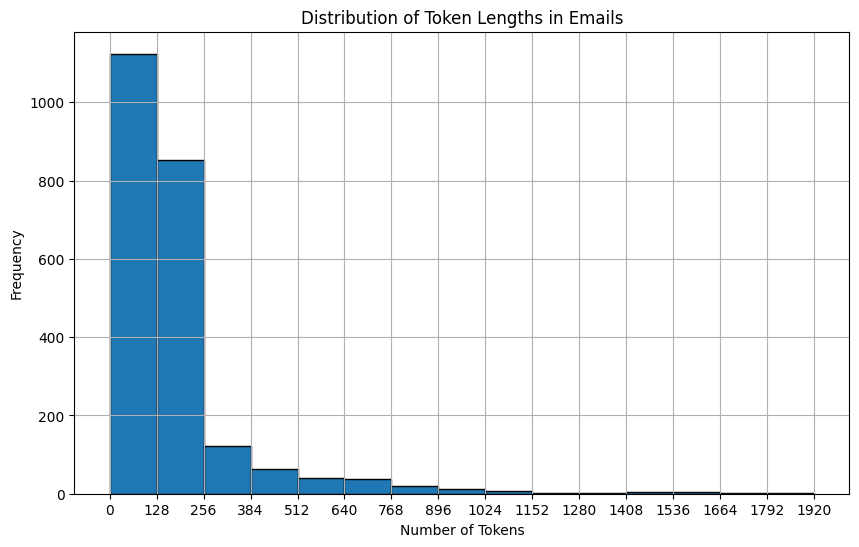

In [8]:
import numpy as np
import matplotlib.pyplot as plt

print("[*] Computing token lengths for training set...")

# Compute full token lengths without truncation
train_df["token_size"] = train_df["text"].apply(lambda x: len(tokenizer.encode(x, truncation=False)))

# Basic statistics
distribution = train_df["token_size"].describe()
print("\nToken length distribution (train_df):")
print(distribution)

# Plot histogram (same binning style as LLM AuthorBench)
bins = np.arange(0, 2000, 128)
plt.figure(figsize=(10, 6))
plt.hist(train_df["token_size"], bins=bins, edgecolor='black')
plt.title("Distribution of Token Lengths in Emails")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.xticks(bins)
plt.grid(True)
plt.show()

# Class and Metrics

In [9]:
import torch
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

class EmailDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.texts = df["text"].tolist()
        self.labels = df["y"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_attention_mask=True
        )
        return {
            "input_ids": torch.tensor(enc["input_ids"], dtype=torch.long),
            "attention_mask": torch.tensor(enc["attention_mask"], dtype=torch.long),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

train_ds = EmailDataset(train_split, tokenizer)
val_ds   = EmailDataset(val_split, tokenizer)
test_ds  = EmailDataset(test_df, tokenizer)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=-1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Train and Validate

In [13]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    logging_strategy="steps",
    logging_steps=100,
    report_to="none",
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

print("[*] Training...")
trainer.train()
print("[*] Validation evaluation:")
trainer.evaluate()

/tmp/ipython-input-1875397301.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


[*] Training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.431100,0.155321,0.961039,0.961293,0.961039,0.960974
2,0.137800,0.174380,0.956710,0.957956,0.956710,0.956557
3,0.067800,0.110156,0.978355,0.978570,0.978355,0.978381


[*] Validation evaluation:


{'eval_loss': 0.1101563423871994,
 'eval_accuracy': 0.9783549783549783,
 'eval_precision': 0.9785698423273372,
 'eval_recall': 0.9783549783549783,
 'eval_f1': 0.9783810960281548,
 'eval_runtime': 1.8543,
 'eval_samples_per_second': 124.574,
 'eval_steps_per_second': 4.314,
 'epoch': 3.0}

# Evaluate on Test Set

[*] Predicting on TEST set...



=== External TEST Results ===
              precision    recall  f1-score   support

           0     1.0000    0.2500    0.4000        20
           1     0.7143    0.3333    0.4545        15
           2     0.3947    1.0000    0.5660        15

    accuracy                         0.5000        50
   macro avg     0.7030    0.5278    0.4735        50
weighted avg     0.7327    0.5000    0.4662        50



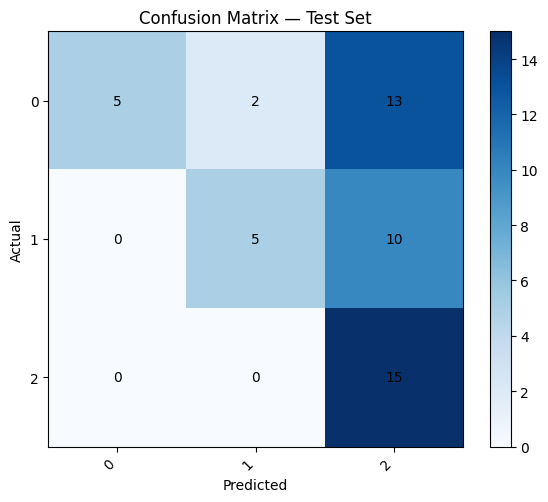

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

print("[*] Predicting on TEST set...")
pred = trainer.predict(test_ds)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

label_names = [str(c) for c in encoder.classes_]
labels_idx  = np.arange(len(label_names))

print("\n=== External TEST Results ===")
print(classification_report(
    y_true,
    y_pred,
    labels=labels_idx,
    target_names=label_names,
    digits=4,
    zero_division=0
))

cm = confusion_matrix(y_true, y_pred, labels=labels_idx)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix — Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(range(len(label_names)), label_names, rotation=45, ha="right")
plt.yticks(range(len(label_names)), label_names)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()
